# MNIST with bare `tensorflow`
The purpose of this notebook is to convert the `keras` implementation of MNIST MLP in the notebook cpu-gpu-mnist with a bare `tensorflow` implementation, which will hopefully be faster.

I'm getting a lot of my code from [this](https://towardsdatascience.com/first-contact-with-tensorflow-estimator-69a5e072998d) tutorial on estimators, plus some extra code on inferences from [this](https://medium.com/@vincentteyssier/tensorflow-estimator-tutorial-on-real-life-data-aa0fca773bb) blog.

## Issues
- For some reason, the `keras` implementation of this project can train MNIST to high accuracy (around 95%) with 5 epochs, but this can only do it after 20 epochs. I'm not sure why.

## Imports and Global Variables
First, we import the required libraries.

In [1]:
import os
import sys
import time
import tensorflow as tf
import numpy as np

Create some global variables

In [21]:
NUM_CLASSES = 10
NUM_CHANNELS = 1
IMG_SIZE = 28
LEARNING_RATE = 0.001 # Learning rate of RMSProp keras optimizer. Original was 0.05.
NUM_EPOCHS = 1

start_power = 0
end_power = 4
BATCH_SIZES = []
for i in range(start_power, end_power):
    BATCH_SIZES += list(range(10**i, 10**(i+1), 10**i))
BATCH_SIZES += [10**end_power]
BATCH_SIZES = [128]

## Define the Model
We will define a model class for MNIST just as `keras` does automatically.

In [3]:
class Model(object):
    def __call__(self, inputs):
        net = tf.layers.dense(inputs, 512, activation=tf.nn.relu, name='dense1')
        net = tf.layers.dropout(net, rate=0.2, name='drop1')
        net = tf.layers.dense(net, 512, activation=tf.nn.relu, name='dense2')
        net = tf.layers.dropout(net, rate=0.2, name='drop2')
        logits = tf.layers.dense(net, NUM_CLASSES, activation=tf.nn.softmax, name='dense3')
        return logits

We need a function to set the behavior of our `Estimator`:

In [22]:
def model_fn(features, labels, mode):
    '''
    Arguments:
        features: items returned from input_fn
        labels: second item returned from input_fn
        mode: the mode the estimator is running in (basically training, validation or prediction). Either
            - tf.estimator.ModeKeys.TRAIN
            - tf.estimator.ModeKeys.EVAL
            - tf.estimator.ModeKeys.PREDICT
    Returns:
        tf.estimator.EstimatorSpec containing
            - the train/loss ops for training
            - loss and metrics for evaluation
            - predictions for inference
    '''
    
    model = Model()
    global_step=tf.train.get_global_step()
    
    # CNN:
    # images = tf.reshape(features, [-1, _IMG_SIZE, _IMG_SIZE, _NUM_CHANNELS])
    
    # MLP:
    images = tf.reshape(features, [-1, IMG_SIZE * IMG_SIZE])
    
    
    logits = model(images)
    predicted_logit = tf.argmax(input=logits, axis=1, 
                                output_type=tf.int32)
    probabilities = tf.nn.softmax(logits)
    
    #PREDICT
    predictions = {
      "predicted_logit": predicted_logit,
      "probabilities": probabilities
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,  
                                        predictions=predictions)
    with tf.name_scope('loss'):
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(
                labels=labels, logits=logits, scope='loss')
        tf.summary.scalar('loss', cross_entropy)
    with tf.name_scope('accuracy'):
        accuracy = tf.metrics.accuracy(
                labels=labels, predictions=predicted_logit, name='acc')
        tf.summary.scalar('accuracy', accuracy[1])
        #EVAL
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(
                mode=mode,
                loss=cross_entropy,
                eval_metric_ops={'accuracy/accuracy': accuracy},
                evaluation_hooks=None)
       
    
    # Create a SGR optimizer 
    optimizer = tf.train.GradientDescentOptimizer(    
                learning_rate=LEARNING_RATE)
    train_op = optimizer.minimize( 
                cross_entropy,global_step=global_step)
    
    # Create a hook to print acc, loss & global step every 100 iter.   
    train_hook_list= []
    train_tensors_log = {'accuracy': accuracy[1],
                         'loss': cross_entropy,
                         'global_step': global_step}
    train_hook_list.append(tf.train.LoggingTensorHook(
        tensors=train_tensors_log, every_n_iter=100))
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(
          mode=mode,
          loss=cross_entropy,
          train_op=train_op,
          training_hooks=train_hook_list)


## Training and Evaluation
We will now train and evaluate the model class we created above.

In [5]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns a np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns a np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

print("Train size", train_data.shape[0])
print("Eval size", eval_data.shape[0])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

We need a function to describe the behavior of the model during evaluation.

In [6]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=eval_data,
        y=eval_labels,
        num_epochs=1,
        shuffle=False)

## Run
Now we need to actually call all the functions we have defined above by training and evaluating the mnist model.

In [23]:
batch_train_data = []
batch_inference_data = []
global device

def train(_):
    with tf.device(device):
        image_classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=None)
            # set model_dir to make model progress permanent
        _train = []
        _inference = []
        for batch_size in BATCH_SIZES:
            # Train
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x=train_data,
                y=train_labels,
                batch_size=batch_size,
                num_epochs=1,
                shuffle=True)

            start_time = time.time()
            for i in range(NUM_EPOCHS):
                epoch_start_time = time.time()
                print("Epoch " + str(i+1) + '/' + str(NUM_EPOCHS)+': ', end = '')
                image_classifier.train(input_fn=train_input_fn)
                metrics = image_classifier.evaluate(input_fn=eval_input_fn)
                epoch_end_time = time.time()
                print('Accuracy:', metrics['accuracy/accuracy'], '\tLoss:', metrics['loss'],
                      '\tTime:', epoch_end_time - epoch_start_time, 's')
            end_time = time.time()
            iterations = NUM_EPOCHS * (train_data.shape[0] / batch_size)
            train_time = (end_time - start_time) / iterations

            # Predict
            predict_data = np.random.rand(batch_size, IMG_SIZE**2).astype('float32')
            predict_input_fn = tf.estimator.inputs.numpy_input_fn(
                x=predict_data,
                y=None,
                batch_size=batch_size,
                num_epochs=1,
                shuffle=True)
            start_time = time.time()

            INFERENCE_NUM = 1

            for i in range(INFERENCE_NUM):
                preds = image_classifier.predict(predict_input_fn)
                for i in range(batch_size):
                    next(preds)
            end_time = time.time()
            inference_time = (end_time - start_time) / batch_size / INFERENCE_NUM
            _train.append(train_time)
            _inference.append(inference_time)
            print('\n','Batch size:', batch_size, '\tTrain time:', train_time, '\tInference time', inference_time)
            print('+'*100)
        batch_train_data.append(_train)
        batch_inference_data.append(_inference)

tf.logging.set_verbosity(0)

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
device = '/cpu:0'
try:
    tf.app.run(train)
except SystemExit:
    pass
    
print()
print("TRAIN ON GPUS")
print()
print('+'*100)
device = '/gpu:0'
try:
    tf.app.run(train)
except SystemExit:
    pass

print()
print('+'*47, "DONE", '+'*47)


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.1274 	Loss: 2.3020768 	Time: 2.0638389587402344 s

 Batch size: 128 	Train time: 0.004804930530894886 	Inference time 0.0013435501605272293
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRAIN ON GPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/1: Accuracy: 0.1185 	Loss: 2.3031187 	Time: 1.9306581020355225 s

 Batch size: 128 	Train time: 0.004494902454723011 	Inference time 0.0014064330607652664
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++ DONE +++++++++++++++++++++++++++++++++++++++++++++++


## Graphing Data
Now we will graph the data we have collected above. First we import the `matplotlib` libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(BATCH_SIZES)

Then we plot the train time and inference times on CPUs and GPUs as a function of batch size.

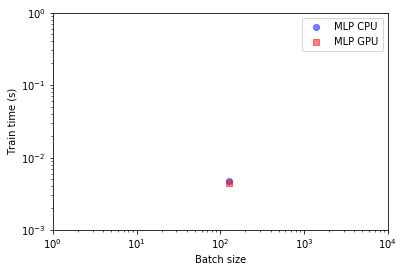

In [26]:
plt.scatter(x, batch_train_data[0], c='b', alpha = 0.5)
plt.scatter(x, batch_train_data[1], c='r', alpha = 0.5, marker='s')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.001, 1])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

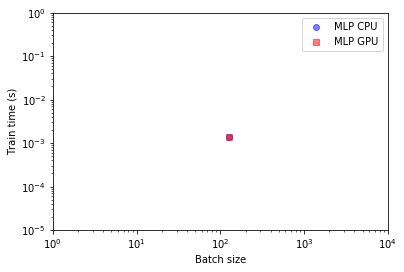

In [27]:
plt.scatter(x, batch_inference_data[0], c='b', alpha = 0.5)
plt.scatter(x, batch_inference_data[1], c='r', alpha = 0.5, marker='s')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.00001, 1])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

We can also plot the performance gain in using GPUs over CPUs.

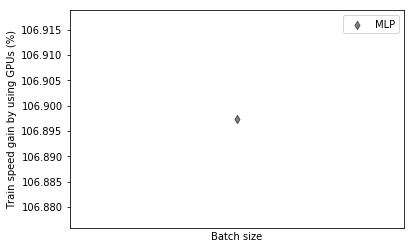

In [28]:
def get_improvement(cpu_times, gpu_times):
    gain = []
    for i in range(len(cpu_times)):
        gain.append(cpu_times[i] / gpu_times[i] * 100)
    return np.array(gain)

gain_train = get_improvement(batch_train_data[0], batch_train_data[1])

plt.scatter(x, gain_train, c='k', alpha = 0.5, marker = 'd')
plt.xlabel('Batch size')
plt.ylabel('Train speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.show()

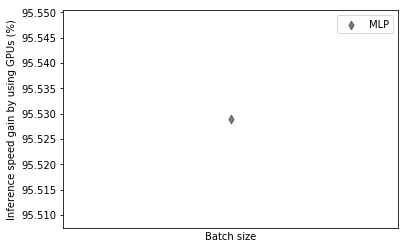

In [29]:
gain_inference = get_improvement(batch_inference_data[0], batch_inference_data[1])

plt.scatter(x, gain_inference, c='k', alpha = 0.5, marker='d')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP'])
plt.show()

This concludes the experiment.